In [80]:
## pip install lightgbm

In [81]:
## pip install catboost

In [82]:
## pip install ipywidgets

In [83]:
import numpy as np
import pandas as pd
import lightgbm
from lightgbm import LGBMRegressor
import catboost
from catboost import CatBoostRegressor
import sklearn
from sklearn.model_selection import KFold
import IPython
from IPython.display import clear_output
import copy
import matplotlib.pyplot as plt

In [84]:
# import datasets
train = pd.read_csv('../dataset/train.csv')
test = pd.read_csv('../dataset/test.csv')
building = pd.read_csv('../dataset/building_info.csv')
submission = pd.read_csv('../dataset/sample_submission.csv')

In [85]:
display(train)
display(test)

,num_date_time,건물번호,일시,기온(C),강수량(mm),풍속(m/s),습도(%),일조(hr),일사(MJ/m2),전력소비량(kWh)
0,1_20220601 00,1,20220601 00,18.6,NaN,0.9,42.0,NaN,NaN,1085.28
1,1_20220601 01,1,20220601 01,18.0,NaN,1.1,45.0,NaN,NaN,1047.36
2,1_20220601 02,1,20220601 02,17.7,NaN,1.5,45.0,NaN,NaN,974.88
3,1_20220601 03,1,20220601 03,16.7,NaN,1.4,48.0,NaN,NaN,953.76
4,1_20220601 04,1,20220601 04,18.4,NaN,2.8,43.0,NaN,NaN,986.40
...,...,...,...,...,...,...,...,...,...,...
203995,100_20220824 19,100,20220824 19,23.1,NaN,0.9,86.0,0.5,NaN,881.04
203996,100_20220824 20,100,20220824 20,22.4,NaN,1.3,86.0,0.0,NaN,798.96
203997,100_20220824 21,100,20220824 21,21.3,NaN,1.0,92.0,NaN,NaN,825.12
203998,100_20220824 22,100,20220824 22,21.0,NaN,0.3,94.0,NaN,NaN,640.08


,num_date_time,건물번호,일시,기온(C),강수량(mm),풍속(m/s),습도(%)
0,1_20220825 00,1,20220825 00,23.5,0.0,2.2,72
1,1_20220825 01,1,20220825 01,23.0,0.0,0.9,72
2,1_20220825 02,1,20220825 02,22.7,0.0,1.5,75
3,1_20220825 03,1,20220825 03,22.1,0.0,1.3,78
4,1_20220825 04,1,20220825 04,21.8,0.0,1.0,77
...,...,...,...,...,...,...,...
16795,100_20220831 19,100,20220831 19,22.5,0.0,0.9,84
16796,100_20220831 20,100,20220831 20,20.7,0.0,0.4,95
16797,100_20220831 21,100,20220831 21,20.2,0.0,0.4,98
16798,100_20220831 22,100,20220831 22,20.1,0.0,1.1,97


In [86]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 204000 entries, 0 to 203999
Data columns (total 10 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   num_date_time  204000 non-null  object 
 1   건물번호           204000 non-null  int64  
 2   일시             204000 non-null  object 
 3   기온(C)          204000 non-null  float64
 4   강수량(mm)        43931 non-null   float64
 5   풍속(m/s)        203981 non-null  float64
 6   습도(%)          203991 non-null  float64
 7   일조(hr)         128818 non-null  float64
 8   일사(MJ/m2)      116087 non-null  float64
 9   전력소비량(kWh)     204000 non-null  float64
dtypes: float64(7), int64(1), object(2)
memory usage: 15.6+ MB


In [87]:
train_df = train.copy()

train_df = train_df.drop(columns =  ['num_date_time', '일조(hr)', '일사(MJ/m2)', '강수량(mm)'])
train_df = train_df.rename(columns = {'기온(C)':'기온', '풍속(m/s)':'풍속', '습도(%)':'습도', '전력소비량(kWh)':'전력소비량'})

train_df['일시'] = pd.to_datetime(train_df['일시'])
train_df['시간'] = train_df['일시'].dt.hour
train_df['요일'] = train_df['일시'].dt.weekday

holiday = ['2022-06-06', '2022-08-15']
train_df['주말'] = train_df['요일'].isin([5,6]).astype(int)
train_df['공휴일'] = train_df['일시'].isin([5,6]).astype(int)
train_df['휴일'] = train_df['주말'] + train_df['공휴일']

T = train_df['기온']
W = train_df['풍속']
RH = train_df['습도']
train_df['열지수'] = -42.379 + 2.04901523*T + 10.14333127*RH - .22475541*T*RH - .00683783*T*T - .05481717*RH*RH + .00122874*T*T*RH + .00085282*T*RH*RH - .00000199*T*T*RH*RH
train_df['열지수'] = pd.cut(train_df['열지수'], bins = [0, 68, 75, 80, 350], labels = [0, 1, 2, 3])
train_df['체감온도'] = 13.12 + 0.6215*T - 11.37*(W)**0.16 + 0.3965*(W)**0.16*T


train_df['sin_시간'] = np.sin(2*np.pi*(train_df['시간'])/23)
train_df['cos_시간'] = np.cos(2*np.pi*(train_df['시간'])/23)
train_df['sin_요일'] = np.sin(2*np.pi*(train_df['요일'])/6)
train_df['cos_요일'] = np.cos(2*np.pi*(train_df['요일'])/6)

train_df = train_df.fillna(0)
train_df = train_df.drop(columns = ['일시', '주말', '공휴일', '시간', '요일'])

In [88]:
T = 9/5*train_df['기온']
train_df['불쾌지수'] = T - 0.55*(1-train_df['습도']/100)*(T-26)+32
train_df['불쾌지수'] = pd.cut(train_df['불쾌지수'], bins = [0, 68, 75, 80, 200], labels = [0, 1, 2, 3])

(array([22498.,     0.,     0., 59862.,     0.,     0., 80715.,     0.,
            0., 40925.]),
 array([0. , 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3. ]),
 <BarContainer object of 10 artists>)

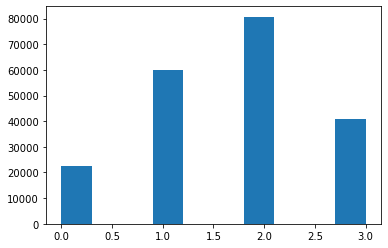

In [89]:
plt.hist(train_df['불쾌지수'])

In [90]:
train_df

,건물번호,기온,풍속,습도,전력소비량,휴일,열지수,체감온도,sin_시간,cos_시간,sin_요일,cos_요일,불쾌지수
0,1,18.6,0.9,42.0,1085.28,0,3,20.751584,0.000000e+00,1.000000,0.866025,-0.5,0
1,1,18.0,1.1,45.0,1047.36,0,3,20.008954,2.697968e-01,0.962917,0.866025,-0.5,0
2,1,17.7,1.5,45.0,974.88,0,3,19.476910,5.195840e-01,0.854419,0.866025,-0.5,0
3,1,16.7,1.4,48.0,953.76,0,3,18.487958,7.308360e-01,0.682553,0.866025,-0.5,0
4,1,18.4,2.8,43.0,986.40,0,3,19.751534,8.878852e-01,0.460065,0.866025,-0.5,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
203995,100,23.1,0.9,86.0,881.04,0,3,25.302757,-8.878852e-01,0.460065,0.866025,-0.5,1
203996,100,22.4,1.3,86.0,798.96,0,3,24.446518,-7.308360e-01,0.682553,0.866025,-0.5,1
203997,100,21.3,1.0,92.0,825.12,0,3,23.433400,-5.195840e-01,0.854419,0.866025,-0.5,1
203998,100,21.0,0.3,94.0,640.08,0,3,23.661275,-2.697968e-01,0.962917,0.866025,-0.5,1


In [91]:
def CDH(x):
    y = []
    for i in range(len(x)):
        if i<11:
            y.append(np.sum(x[:(i+1)]-26))
        else:
            y.append(np.sum(x[(i-11):(i+1)]-26))
    return np.array(x)

In [92]:
cdhs = np.array([])

for num in range(1, 101):
    temp = train_df[train_df['건물번호'] == num]
    cdh = CDH(temp['기온'].values)
    cdhs = np.concatenate([cdhs, cdh])

train_df['CDH'] = cdhs

In [93]:
def detect_outliers(df,ratio): #iqr 이상치제거 
    outlier_indices = [] 
    Q1 = np.percentile(df, 25) 
    Q3 = np.percentile(df, 75) 
    IQR = Q3 - Q1 
    outlier_step = ratio * IQR 
    return ~(df < Q1 - outlier_step) | (df > Q3 + outlier_step)


c:\Users\LimJaeSung\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 44592 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\Users\LimJaeSung\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 50728 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\Users\LimJaeSung\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 54413 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\Users\LimJaeSung\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 49549 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\Users\LimJaeSung\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 49845 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\Users\LimJaeSung\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarni

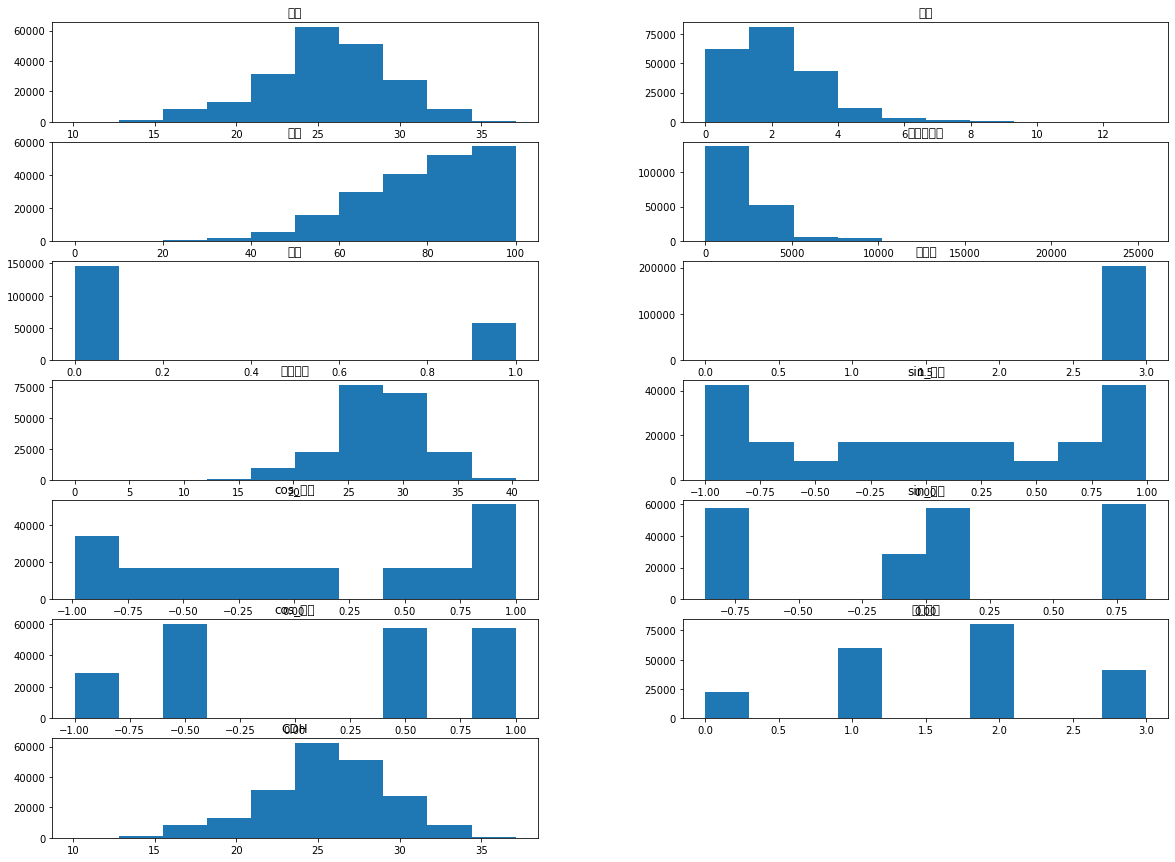

In [94]:
import matplotlib.gridspec as gridspec 

grid = gridspec.GridSpec(7,2)
fig = plt.figure(figsize = (20, 15))
plt.subplots_adjust(wspace = 0.3, hspace = 0.2)

for idx, feature in enumerate(train_df.columns[1:]):
    ax = plt.subplot(grid[idx])
    plt.hist(train_df[feature])
    plt.title(f"{feature}")

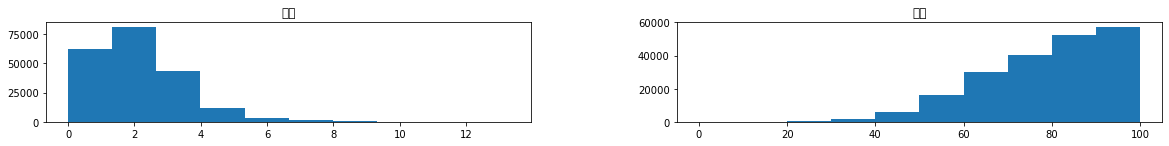

In [95]:
import matplotlib.gridspec as gridspec 

grid = gridspec.GridSpec(7,2)
fig = plt.figure(figsize = (20, 15))
plt.subplots_adjust(wspace = 0.3, hspace = 0.2)

for idx, feature in enumerate(['풍속', '습도']):
    ax = plt.subplot(grid[idx])
    plt.hist(train_df[feature])
    plt.title(f"{feature}")

In [96]:
train_df['풍속'] = np.log1p(train_df['풍속'])
train_df['습도'] = np.log1p(train_df['습도'])
train_df['전력소비량'] = np.log1p(train_df['전력소비량'])

In [97]:
test_df = test.copy()

test_df = test_df.drop(columns =  ['num_date_time', '강수량(mm)'])
test_df = test_df.rename(columns = {'기온(C)':'기온', '풍속(m/s)':'풍속', '습도(%)':'습도'})
test_df['일시'] = pd.to_datetime(test_df['일시'])
test_df['시간'] = test_df['일시'].dt.hour
test_df['요일'] = test_df['일시'].dt.weekday
test_df['휴일'] = test_df['요일'].isin([5,6]).astype(int)
test_df = test_df.fillna(0)
test_df = test_df.drop(columns = '일시')

T = 9/5*test_df['기온']
test_df['불쾌지수'] = T - 0.55*(1-test_df['습도']/100)*(T-26)+32
test_df['불쾌지수'] = pd.cut(test_df['불쾌지수'], bins = [0, 68, 75, 80, 200], labels = [1, 2, 3, 4])

cdhs = np.array([])
for num in range(1, 101):
    temp = test_df[test_df['건물번호'] == num]
    cdh = CDH(temp['기온'].values)
    cdhs = np.concatenate([cdhs, cdh])

test_df['CDH'] = cdhs

test_df['풍속'] = np.log1p(test_df['풍속'])
test_df['습도'] = np.log1p(test_df['습도'])

T = test_df['기온']
W = test_df['풍속']
RH = test_df['습도']
test_df['열지수'] = -42.379 + 2.04901523*T + 10.14333127*RH - .22475541*T*RH - .00683783*T*T - .05481717*RH*RH + .00122874*T*T*RH + .00085282*T*RH*RH - .00000199*T*T*RH*RH
test_df['열지수'] = pd.cut(test_df['열지수'], bins = [0, 68, 75, 80, 350], labels = [0, 1, 2, 3])
test_df['체감온도'] = 13.12 + 0.6215*T - 11.37*(W)**0.16 + 0.3965*(W)**0.16*T


test_df['sin_시간'] = np.sin(2*np.pi*(test_df['시간'])/23)
test_df['cos_시간'] = np.cos(2*np.pi*(test_df['시간'])/23)
test_df['sin_요일'] = np.sin(2*np.pi*(test_df['요일'])/6)
test_df['cos_요일'] = np.cos(2*np.pi*(test_df['요일'])/6)

test_df.drop(columns = ['시간'])

test_df = test_df[['건물번호', '기온', '풍속', '습도', '휴일', '불쾌지수', 'CDH', '열지수', '체감온도', 'sin_시간', 'cos_시간', 'sin_요일', 'cos_요일']]
test_input  = []
for i in range(1,101):
    test_input.append(test_df[test_df['건물번호']==i])

for i in range(100):
    test_input[i] = test_input[i].drop(columns = ['건물번호'])


In [98]:
building

,건물번호,건물유형,연면적(m2),냉방면적(m2),태양광용량(kW),ESS저장용량(kWh),PCS용량(kW)
0,1,건물기타,110634.00,39570.00,-,-,-
1,2,건물기타,122233.47,99000.00,-,-,-
2,3,건물기타,171243.00,113950.00,40,-,-
3,4,건물기타,74312.98,34419.62,60,-,-
4,5,건물기타,205884.00,150000.00,-,2557,1000
...,...,...,...,...,...,...,...
95,96,호텔및리조트,93314.00,60500.00,-,-,-
96,97,호텔및리조트,55144.67,25880.00,-,-,-
97,98,호텔및리조트,53578.62,17373.75,-,-,-
98,99,호텔및리조트,53499.00,40636.00,-,-,-


c:\Users\LimJaeSung\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 44148 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\Users\LimJaeSung\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 47932 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\Users\LimJaeSung\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 48264 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\Users\LimJaeSung\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 54840 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\Users\LimJaeSung\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 44592 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\Users\LimJaeSung\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarni

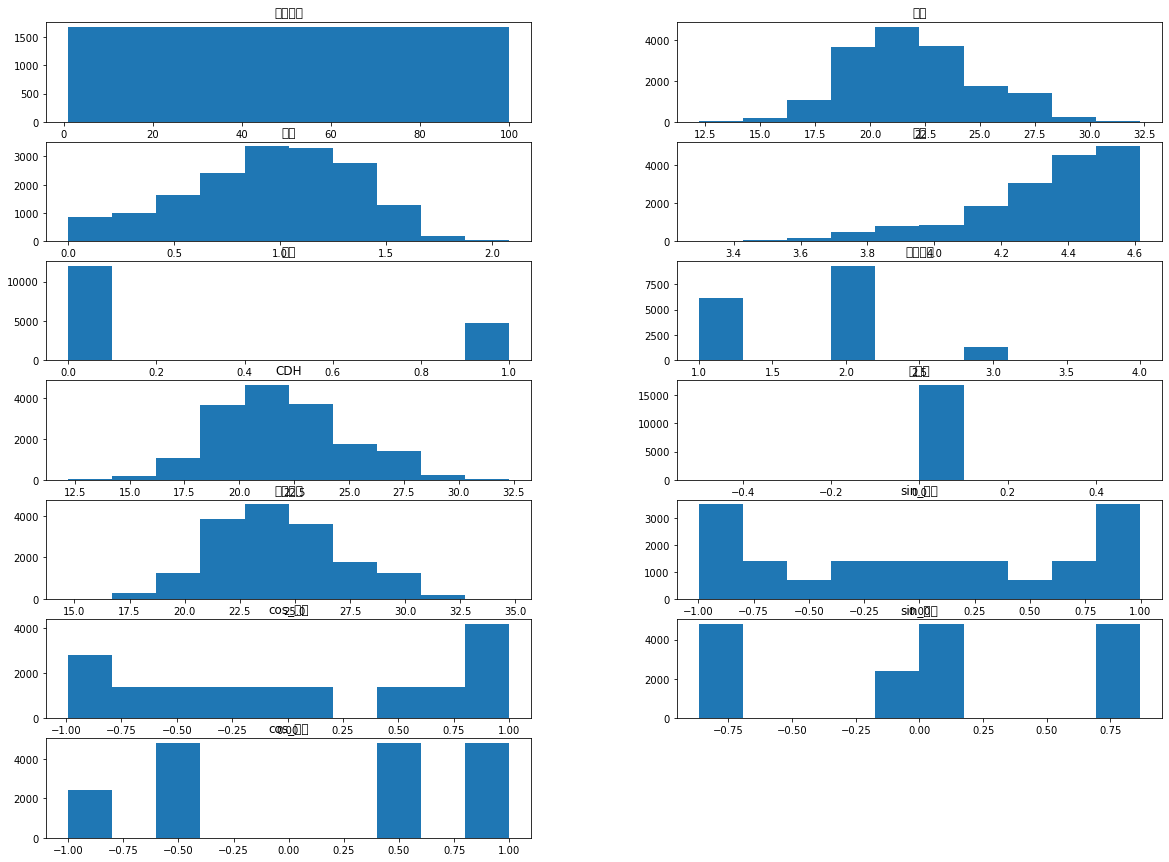

In [99]:
import matplotlib.gridspec as gridspec 

grid = gridspec.GridSpec(7,2)
fig = plt.figure(figsize = (20, 15))
plt.subplots_adjust(wspace = 0.3, hspace = 0.2)

for idx, feature in enumerate(test_df.columns):
    ax = plt.subplot(grid[idx])
    plt.hist(test_df[feature])
    plt.title(f"{feature}")

In [100]:
train_df = train_df[['전력소비량', '건물번호', '기온', '풍속', '습도', '휴일', '불쾌지수', 'CDH', '열지수', '체감온도', 'sin_시간', 'cos_시간', 'sin_요일', 'cos_요일']]

train_dfs  = []
for i in range(1,101):
    train_dfs.append(train_df[train_df['건물번호']==i])


In [101]:
for i in range(100):
    train_dfs[i] = train_dfs[i].drop(columns = ['건물번호'])

In [102]:
train_input = [] 
train_target = []

for i in range(len(train_dfs)):
    train_input.append(copy.deepcopy(train_dfs[i][train_dfs[i].columns[1:]])) 
    train_target.append(copy.deepcopy(train_dfs[i][train_dfs[i].columns[0]]))

In [103]:
# 이상치처리
# for i in range(100):    
#     idx = detect_outliers(train_target[i],1.25)
#     train_target[i] = train_target[i][idx]
#     train_input[i] = train_input[i][idx]

(array([1.00000e+01, 0.00000e+00, 0.00000e+00, 2.20000e+01, 0.00000e+00,
        0.00000e+00, 2.70000e+01, 0.00000e+00, 0.00000e+00, 2.03941e+05]),
 array([0. , 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3. ]),
 <BarContainer object of 10 artists>)

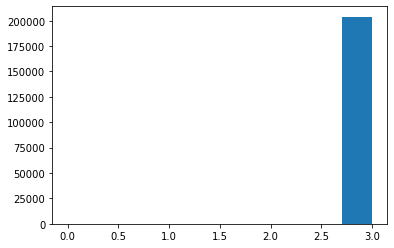

In [104]:
plt.hist(train_df['열지수'])

In [105]:
display(train_input[0])
display(test_input[0])

,기온,풍속,습도,휴일,불쾌지수,CDH,열지수,체감온도,sin_시간,cos_시간,sin_요일,cos_요일
0,18.6,0.641854,3.761200,0,0,18.6,3,20.751584,0.000000e+00,1.000000,0.866025,-0.5
1,18.0,0.741937,3.828641,0,0,18.0,3,20.008954,2.697968e-01,0.962917,0.866025,-0.5
2,17.7,0.916291,3.828641,0,0,17.7,3,19.476910,5.195840e-01,0.854419,0.866025,-0.5
3,16.7,0.875469,3.891820,0,0,16.7,3,18.487958,7.308360e-01,0.682553,0.866025,-0.5
4,18.4,1.335001,3.784190,0,0,18.4,3,19.751534,8.878852e-01,0.460065,0.866025,-0.5
...,...,...,...,...,...,...,...,...,...,...,...,...
2035,25.5,1.360977,4.158883,0,1,25.5,3,27.475127,-8.878852e-01,0.460065,0.866025,-0.5
2036,25.0,1.280934,4.204693,0,1,25.0,3,26.959240,-7.308360e-01,0.682553,0.866025,-0.5
2037,24.6,0.832909,4.219508,0,1,24.6,3,26.723515,-5.195840e-01,0.854419,0.866025,-0.5
2038,24.1,1.131402,4.262680,0,1,24.1,3,26.055113,-2.697968e-01,0.962917,0.866025,-0.5


,기온,풍속,습도,휴일,불쾌지수,CDH,열지수,체감온도,sin_시간,cos_시간,sin_요일,cos_요일
0,23.5,1.163151,4.290459,0,2,23.5,0,25.622769,0.000000e+00,1.000000,1.224647e-16,-1.0
1,23.0,0.641854,4.290459,0,2,23.0,0,25.318126,2.697968e-01,0.962917,1.224647e-16,-1.0
2,22.7,0.916291,4.330733,0,2,22.7,0,24.891512,5.195840e-01,0.854419,1.224647e-16,-1.0
3,22.1,0.832909,4.369448,0,2,22.1,0,24.322968,7.308360e-01,0.682553,1.224647e-16,-1.0
4,21.8,0.693147,4.356709,0,2,21.8,0,24.097678,8.878852e-01,0.460065,1.224647e-16,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
163,23.5,1.098612,4.330733,0,2,23.5,0,25.641885,-8.878852e-01,0.460065,8.660254e-01,-0.5
164,22.4,1.098612,4.394449,0,2,22.4,0,24.515472,-7.308360e-01,0.682553,8.660254e-01,-0.5
165,21.7,0.955511,4.406719,0,2,21.7,0,23.860667,-5.195840e-01,0.854419,8.660254e-01,-0.5
166,21.1,0.693147,4.430817,0,2,21.1,0,23.400887,-2.697968e-01,0.962917,8.660254e-01,-0.5


In [106]:
random_seed = 42
K = [i for i in [5]]
catfeatures = ['휴일', '불쾌지수', '열지수']

cat_mae_params = {
    'objective': 'MAE',
    'n_estimators': 10000,
    'early_stopping_rounds': 4, 
    'cat_features' : catfeatures,
    'one_hot_max_size' : 4
} # catboost hyper parameter

lgbm_mae_params = {
    'objective': 'MAE',
    'boosting_type': 'goss',
    'n_estimators': 10000,
    'early_stopping_round': 15, 
    'num_leaves':39,
    'categorical_feature = name' : catfeatures
} # lightgbm hyper parameter


for k in K: # kfold 의 nspilt 의 값 k
    folds = []
    for i in range(len(train_dfs)):
        cross = KFold(n_splits = k, shuffle = True, random_state = random_seed)
        fold = []
        for train_idx, valid_idx in cross.split(train_input[i], train_target[i]):
            fold.append((train_idx, valid_idx))
        folds.append(fold)
            
    for i in range(len(train_dfs)):
        for fold in range(k):
            print(random_seed, k, i)
            train_idx, valid_idx = folds[i][fold]
            X_train = train_input[i].iloc[train_idx]
            y_train = train_target[i].iloc[train_idx]
            X_valid = train_input[i].iloc[valid_idx]
            y_valid = train_target[i].iloc[valid_idx]                
            # catboost 학습 
            model = CatBoostRegressor(**cat_mae_params)
            model.fit(X_train, y_train, eval_set=[(X_valid, y_valid)])
            v = (np.exp(model.predict(test_input[i][train_input[i].columns]))-1) * 0.3
                
            #lgbm 학습 
            model=LGBMRegressor(**lgbm_mae_params)
            model.fit(X_train, y_train, eval_set=[(X_valid, y_valid)])        
            v += (np.exp(model.predict(test_input[i][train_input[i].columns]))-1) * 0.7
                
            submission['answer'].iloc[(i)*168:(i+1)*168] += v/(len(K)*k)
            clear_output(True)   

submission.to_csv('../submission/answer8.csv', index = False) # 파일 저장

42 5 99
0:	learn: 0.3565190	test: 0.3525457	best: 0.3525457 (0)	total: 3.18ms	remaining: 31.8s
1:	learn: 0.3455395	test: 0.3412001	best: 0.3412001 (1)	total: 5.82ms	remaining: 29.1s
2:	learn: 0.3355493	test: 0.3318354	best: 0.3318354 (2)	total: 8.56ms	remaining: 28.5s
3:	learn: 0.3256861	test: 0.3223081	best: 0.3223081 (3)	total: 11.3ms	remaining: 28.3s
4:	learn: 0.3179103	test: 0.3150925	best: 0.3150925 (4)	total: 14.3ms	remaining: 28.5s
5:	learn: 0.3084052	test: 0.3059246	best: 0.3059246 (5)	total: 17.3ms	remaining: 28.9s
6:	learn: 0.2995614	test: 0.2975094	best: 0.2975094 (6)	total: 20.1ms	remaining: 28.7s
7:	learn: 0.2914077	test: 0.2898564	best: 0.2898564 (7)	total: 22.9ms	remaining: 28.5s
8:	learn: 0.2827168	test: 0.2814620	best: 0.2814620 (8)	total: 25.5ms	remaining: 28.3s
9:	learn: 0.2747784	test: 0.2736887	best: 0.2736887 (9)	total: 28.7ms	remaining: 28.6s
10:	learn: 0.2670293	test: 0.2662354	best: 0.2662354 (10)	total: 31.4ms	remaining: 28.5s
11:	learn: 0.2592560	test: 0.2585

In [111]:
submission

,num_date_time,answer
0,1_20220825 00,1766.623861
1,1_20220825 01,1629.431423
2,1_20220825 02,1529.720194
3,1_20220825 03,1312.555227
4,1_20220825 04,1285.101621
...,...,...
16795,100_20220831 19,843.257648
16796,100_20220831 20,740.302832
16797,100_20220831 21,673.044638
16798,100_20220831 22,577.716342


In [112]:
best = pd.read_csv('../submission/answer7.csv')
update = pd.read_csv('../submission/answer8.csv')

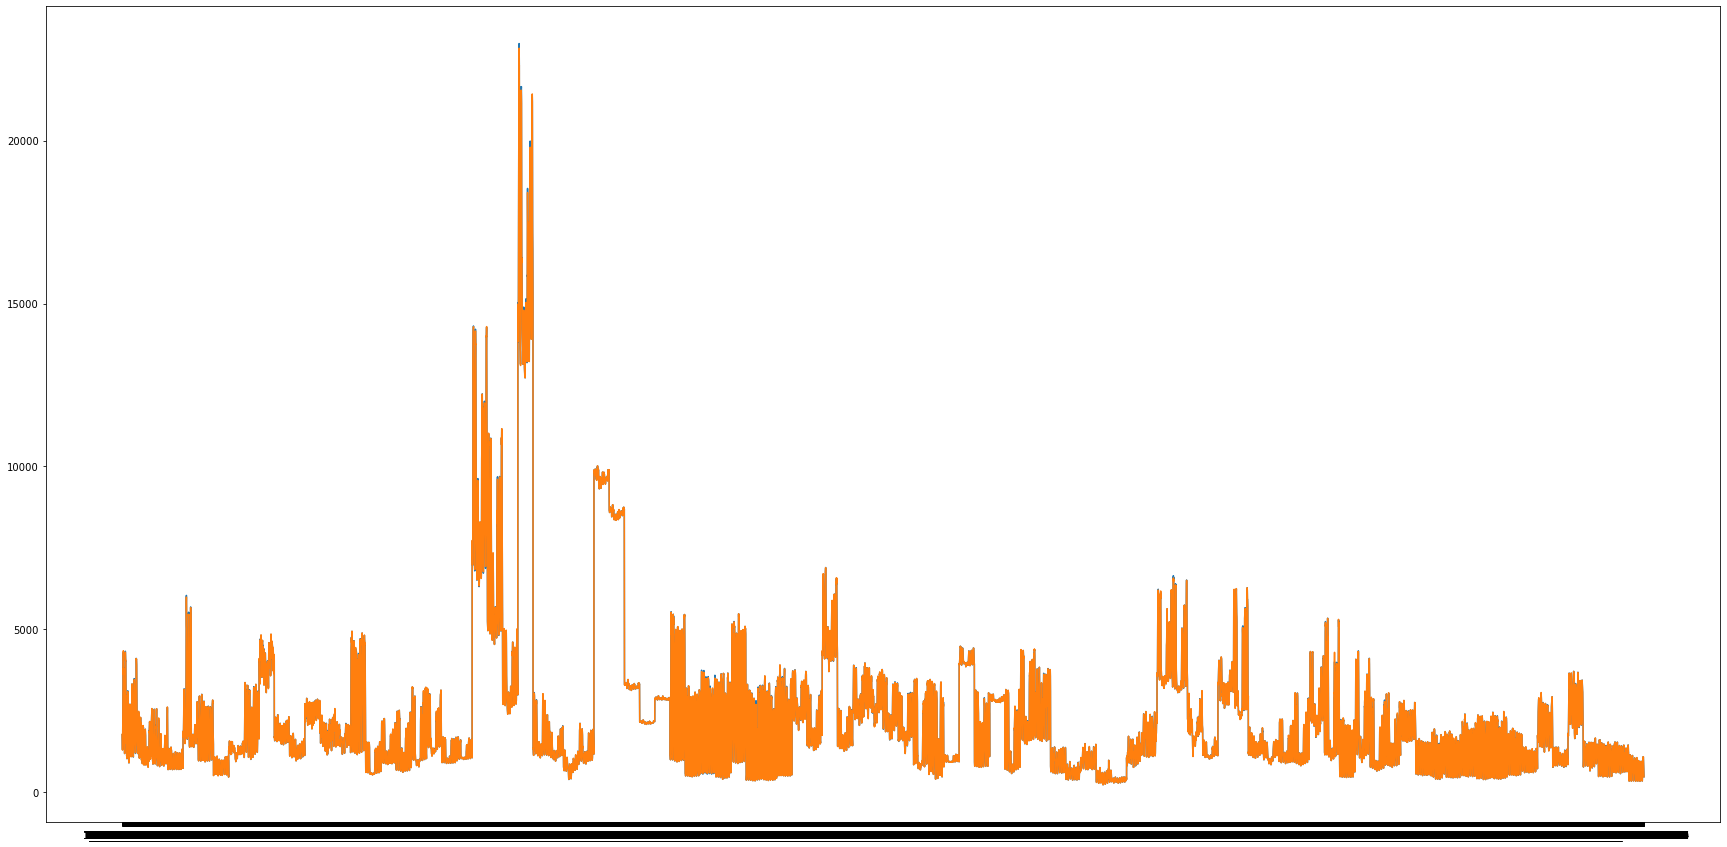

In [113]:
x = np.array(best['num_date_time'])
y = np.array(best['answer'])

x_ = np.array(update['num_date_time'])
y_ = np.array(update['answer'])

plt.figure(figsize = (30, 15))
plt.plot(x, y)
plt.plot(x_, y_)